Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Load the data
data = pd.read_csv("crop_yield.csv")

# Remove rows with Cotton and Soybean crops and the Region column
data = data[~data['Crop'].isin(['Cotton', 'Soybean'])]
data = data.drop(columns=['Region'])

# Split features and targets
X = data.drop(columns=['Days_to_Harvest', 'Yield_tons_per_hectare'])
y = data[['Days_to_Harvest', 'Yield_tons_per_hectare']]

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = ['Soil_Type', 'Crop', 'Weather_Condition']
encoded_categorical = encoder.fit_transform(X[categorical_features])

# Convert boolean features to integers
X['Fertilizer_Used'] = X['Fertilizer_Used'].astype(int)
X['Irrigation_Used'] = X['Irrigation_Used'].astype(int)

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Fertilizer_Used', 'Irrigation_Used']
normalized_numerical = scaler.fit_transform(X[numerical_features])

# Combine processed features
X_processed = np.hstack([normalized_numerical, encoded_categorical])

Fully Connected Neural Network (FCNN)

Using device: cuda
Epoch 1/700, Training Loss: 5803.6196, Validation Loss: 5779.6406
Epoch 2/700, Training Loss: 5784.7852, Validation Loss: 5738.1553
Epoch 3/700, Training Loss: 5743.2715, Validation Loss: 5617.7153
Epoch 4/700, Training Loss: 5622.7500, Validation Loss: 5319.5039
Epoch 5/700, Training Loss: 5324.3438, Validation Loss: 4674.1665
Epoch 6/700, Training Loss: 4678.6045, Validation Loss: 3478.9539
Epoch 7/700, Training Loss: 3482.5815, Validation Loss: 1713.7843
Epoch 8/700, Training Loss: 1715.8907, Validation Loss: 618.3808
Epoch 9/700, Training Loss: 617.6699, Validation Loss: 2928.6741
Epoch 10/700, Training Loss: 2924.8274, Validation Loss: 1109.8668
Epoch 11/700, Training Loss: 1107.3033, Validation Loss: 394.4665
Epoch 12/700, Training Loss: 393.5162, Validation Loss: 780.6130
Epoch 13/700, Training Loss: 780.8320, Validation Loss: 1271.7244
Epoch 14/700, Training Loss: 1272.5891, Validation Loss: 1535.5160
Epoch 15/700, Training Loss: 1536.6130, Validation Loss: 1

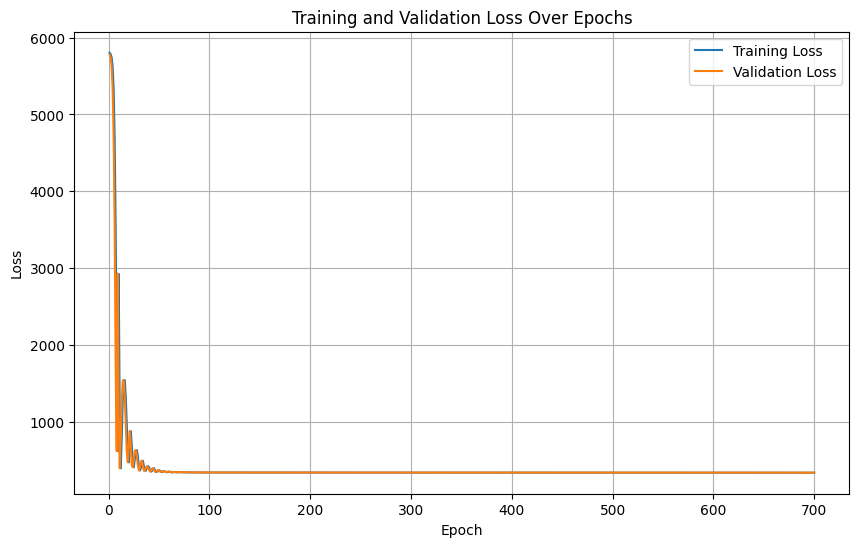


Training Metrics:
Mean Percent Accuracy (Days to Harvest): 76.25%
Mean Percent Accuracy (Yield): 89.03%
Median Percent Accuracy (Days to Harvest): 79.45%
Median Percent Accuracy (Yield): 92.42%
Accuracy Within ±10% (Days to Harvest): 23.59%
Accuracy Within ±10% (Yield): 61.77%
MAE (Days to Harvest): 22.45
MAE (Yield): 0.41
RMSE (Days to Harvest): 25.94
RMSE (Yield): 0.51

Validation Metrics:
Mean Percent Accuracy (Days to Harvest): 76.17%
Mean Percent Accuracy (Yield): 88.74%
Median Percent Accuracy (Days to Harvest): 79.42%
Median Percent Accuracy (Yield): 92.39%
Accuracy Within ±10% (Days to Harvest): 23.46%
Accuracy Within ±10% (Yield): 61.63%
MAE (Days to Harvest): 22.49
MAE (Yield): 0.41
RMSE (Days to Harvest): 25.98
RMSE (Yield): 0.51

Training completed in 40.08 seconds
Final Training Loss: 336.5018
Final Validation Loss: 337.6053


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y.values, test_size=0.2, random_state=88)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Define the neural network
class CropYieldNN(nn.Module):
    def __init__(self, input_dim):
        super(CropYieldNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2)
        self.leaky_relu = nn.LeakyReLU()
        self.swish = nn.SiLU()

    def forward(self, x):
        x = self.swish(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        return self.output(x)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move data tensors to the same device as the model
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)


# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = CropYieldNN(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008, weight_decay=2e-6)


# Train the neural network
n_epochs = 700
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(n_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print progress
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# End time
end_time = time.time()
training_time = end_time - start_time

# Final training and validation loss
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate metrics
def evaluate_model_with_metrics(y_actual, y_pred, tolerance=0.1):
    # Percent accuracy
    percent_accuracies = 100 * (1 - np.abs(y_actual - y_pred) / y_actual)
    mean_percent_accuracy = np.mean(percent_accuracies, axis=0)
    median_percent_accuracy = np.median(percent_accuracies, axis=0)  # Median for robustness

    # Accuracy within tolerance
    within_tolerance = np.abs(y_actual - y_pred) <= (tolerance * y_actual)
    percent_within_tolerance = np.mean(within_tolerance, axis=0) * 100

    # MAE
    mae = np.mean(np.abs(y_actual - y_pred), axis=0)

    # RMSE
    rmse = np.sqrt(np.mean((y_actual - y_pred) ** 2, axis=0))

    return {
        "mean_percent_accuracy": mean_percent_accuracy,
        "median_percent_accuracy": median_percent_accuracy,
        "percent_within_tolerance": percent_within_tolerance,
        "mae": mae,
        "rmse": rmse,
    }

# Evaluate metrics
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).cpu().numpy()
    val_preds = model(X_val_tensor).cpu().numpy()
    y_train_np = y_train_tensor.cpu().numpy()
    y_val_np = y_val_tensor.cpu().numpy()

    # Training metrics
    train_metrics = evaluate_model_with_metrics(y_train_np, train_preds, tolerance=0.1)
    
    # Validation metrics
    val_metrics = evaluate_model_with_metrics(y_val_np, val_preds, tolerance=0.1)

# Print training metrics
print("\nTraining Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {train_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {train_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {train_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {train_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {train_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {train_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {train_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {train_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {train_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {train_metrics['rmse'][1]:.2f}")

# Print validation metrics
print("\nValidation Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {val_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {val_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {val_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {val_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {val_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {val_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {val_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {val_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {val_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {val_metrics['rmse'][1]:.2f}")

print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Support Vector Machine (SVM)

Epoch 1/6000, Training Loss: 54.2268, Validation Loss: 54.1538
Epoch 2/6000, Training Loss: 54.1868, Validation Loss: 54.1138
Epoch 3/6000, Training Loss: 54.1468, Validation Loss: 54.0739
Epoch 4/6000, Training Loss: 54.1068, Validation Loss: 54.0339
Epoch 5/6000, Training Loss: 54.0668, Validation Loss: 53.9940
Epoch 6/6000, Training Loss: 54.0267, Validation Loss: 53.9540
Epoch 7/6000, Training Loss: 53.9867, Validation Loss: 53.9141
Epoch 8/6000, Training Loss: 53.9467, Validation Loss: 53.8742
Epoch 9/6000, Training Loss: 53.9067, Validation Loss: 53.8342
Epoch 10/6000, Training Loss: 53.8667, Validation Loss: 53.7943
Epoch 11/6000, Training Loss: 53.8267, Validation Loss: 53.7543
Epoch 12/6000, Training Loss: 53.7867, Validation Loss: 53.7144
Epoch 13/6000, Training Loss: 53.7467, Validation Loss: 53.6744
Epoch 14/6000, Training Loss: 53.7067, Validation Loss: 53.6345
Epoch 15/6000, Training Loss: 53.6666, Validation Loss: 53.5946
Epoch 16/6000, Training Loss: 53.6266, Validation

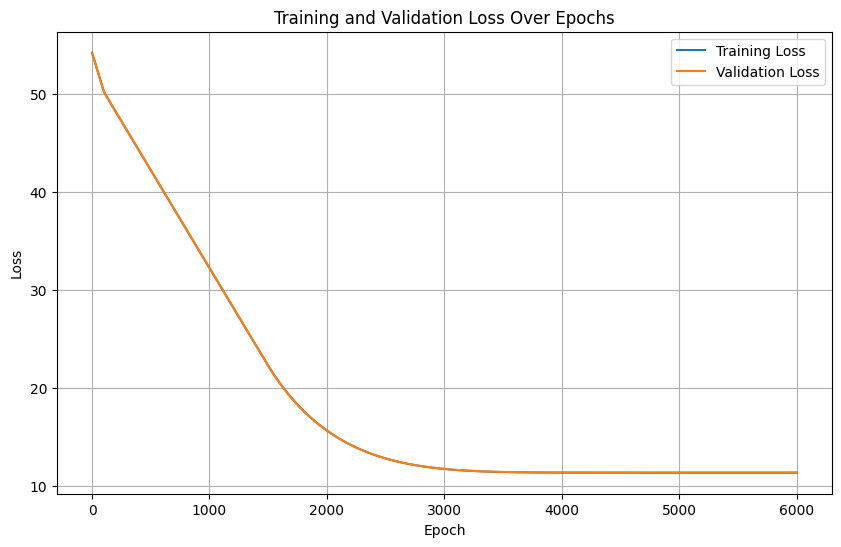


Training Metrics:
Mean Percent Accuracy (Days to Harvest): 76.25%
Mean Percent Accuracy (Yield): 89.17%
Median Percent Accuracy (Days to Harvest): 79.45%
Median Percent Accuracy (Yield): 92.56%
Accuracy Within ±10% (Days to Harvest): 23.58%
Accuracy Within ±10% (Yield): 62.50%
MAE (Days to Harvest): 22.45
MAE (Yield): 0.40
RMSE (Days to Harvest): 25.94
RMSE (Yield): 0.50

Validation Metrics:
Mean Percent Accuracy (Days to Harvest): 76.17%
Mean Percent Accuracy (Yield): 89.00%
Median Percent Accuracy (Days to Harvest): 79.42%
Median Percent Accuracy (Yield): 92.52%
Accuracy Within ±10% (Days to Harvest): 23.47%
Accuracy Within ±10% (Yield): 62.40%
MAE (Days to Harvest): 22.49
MAE (Yield): 0.40
RMSE (Days to Harvest): 25.98
RMSE (Yield): 0.50

Training completed in 16.93 seconds
Final Training Loss: 11.3296
Final Validation Loss: 11.3495


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time


# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y.values, test_size=0.2, random_state=88)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, X_val_tensor = X_train_tensor.to(device), X_val_tensor.to(device)
y_train_tensor, y_val_tensor = y_train_tensor.to(device), y_val_tensor.to(device)

# Define SVM-like regression model
class SVMRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SVMRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, 2)  # Output two targets: Days to Harvest and Yield

    def forward(self, x):
        return self.linear(x)

# Define hinge loss for ε-SVR
class EpsilonSVRLoss(nn.Module):
    def __init__(self, epsilon=0.1):
        super(EpsilonSVRLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        abs_diff = torch.abs(predictions - targets)
        loss = torch.mean(torch.clamp(abs_diff - self.epsilon, min=0))
        return loss

# Instantiate model, loss, and optimizer
input_dim = X_train_tensor.shape[1]
model = SVMRegressor(input_dim).to(device)
criterion = EpsilonSVRLoss(epsilon=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
n_epochs = 6000
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(n_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    train_predictions = model(X_train_tensor)
    train_loss = criterion(train_predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

end_time = time.time()
training_time = end_time - start_time  # Training time in seconds

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
def evaluate_model(y_actual, y_pred, tolerance=0.1):
    # Percent accuracy
    percent_accuracies = 100 * (1 - torch.abs(y_actual - y_pred) / y_actual)
    mean_percent_accuracy = torch.mean(percent_accuracies, axis=0).detach().cpu().numpy()
    median_percent_accuracy = torch.median(percent_accuracies, axis=0).values.detach().cpu().numpy()

    # Accuracy within tolerance
    within_tolerance = torch.abs(y_actual - y_pred) <= (tolerance * y_actual)
    percent_within_tolerance = torch.mean(within_tolerance.float(), axis=0).detach().cpu().numpy() * 100

    # MAE
    mae = torch.mean(torch.abs(y_actual - y_pred), axis=0).detach().cpu().numpy()

    # RMSE
    rmse = torch.sqrt(torch.mean((y_actual - y_pred) ** 2, axis=0)).detach().cpu().numpy()

    return {
        "mean_percent_accuracy": mean_percent_accuracy,
        "median_percent_accuracy": median_percent_accuracy,
        "percent_within_tolerance": percent_within_tolerance,
        "mae": mae,
        "rmse": rmse,
    }

# Get predictions and metrics
train_metrics = evaluate_model(y_train_tensor, train_predictions)
val_metrics = evaluate_model(y_val_tensor, val_predictions)

# Print training metrics
print("\nTraining Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {train_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {train_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {train_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {train_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {train_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {train_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {train_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {train_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {train_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {train_metrics['rmse'][1]:.2f}")

# Print validation metrics
print("\nValidation Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {val_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {val_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {val_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {val_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {val_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {val_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {val_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {val_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {val_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {val_metrics['rmse'][1]:.2f}")

final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")



Linear Regression

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/1500, Training Loss: 5812.4004, Validation Loss: 5617.4453
Epoch 2/1500, Training Loss: 5622.4463, Validation Loss: 5434.1865
Epoch 3/1500, Training Loss: 5439.0835, Validation Loss: 5257.2881
Epoch 4/1500, Training Loss: 5262.0806, Validation Loss: 5086.5278
Epoch 5/1500, Training Loss: 5091.2183, Validation Loss: 4921.6934
Epoch 6/1500, Training Loss: 4926.2837, Validation Loss: 4762.5786
Epoch 7/1500, Training Loss: 4767.0708, Validation Loss: 4608.9849
Epoch 8/1500, Training Loss: 4613.3809, Validation Loss: 4460.7217
Epoch 9/1500, Training Loss: 4465.0234, Validation Loss: 4317.6030
Epoch 10/1500, Training Loss: 4321.8120, Validation Loss: 4179.4521
Epoch 11/1500, Training Loss: 4183.5688, Validation Loss: 4046.0947
Epoch 12/1500, Training Loss: 4050.1216, Validation Loss: 3917.3645
Epoch 13/1500, Training Loss: 3921.3037, Validation Loss: 3793.1025
Epoch 14/1500, Training Loss: 3796.9548, Validation Loss: 3673.1523
Epoch 15/1500, Training Loss: 3676.9192, Validation Loss:

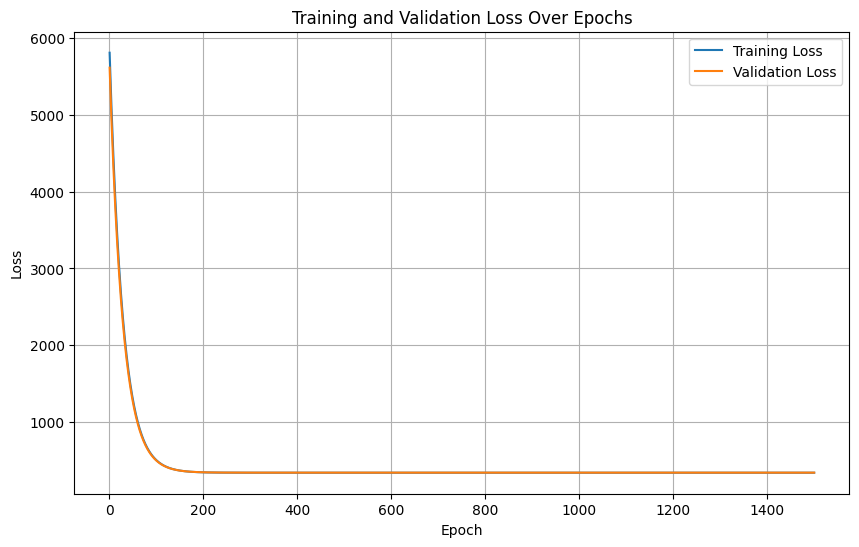


Training Metrics:
Mean Percent Accuracy (Days to Harvest): 76.25%
Mean Percent Accuracy (Yield): 89.19%
Median Percent Accuracy (Days to Harvest): 79.59%
Median Percent Accuracy (Yield): 92.56%
Accuracy Within ±10% (Days to Harvest): 23.72%
Accuracy Within ±10% (Yield): 62.48%
MAE (Days to Harvest): 22.45
MAE (Yield): 0.40
RMSE (Days to Harvest): 25.94
RMSE (Yield): 0.50

Validation Metrics:
Mean Percent Accuracy (Days to Harvest): 76.17%
Mean Percent Accuracy (Yield): 88.99%
Median Percent Accuracy (Days to Harvest): 79.54%
Median Percent Accuracy (Yield): 92.52%
Accuracy Within ±10% (Days to Harvest): 23.60%
Accuracy Within ±10% (Yield): 62.36%
MAE (Days to Harvest): 22.49
MAE (Yield): 0.40
RMSE (Days to Harvest): 25.98
RMSE (Yield): 0.50

Training completed in 2.72 seconds
Final Training Loss: 336.5442
Final Validation Loss: 337.5695


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y.values, test_size=0.2, random_state=88)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor, X_val_tensor = X_train_tensor.to(device), X_val_tensor.to(device)
y_train_tensor, y_val_tensor = y_train_tensor.to(device), y_val_tensor.to(device)

# Define Linear Regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 2)  # Two outputs: Days to Harvest and Yield

    def forward(self, x):
        return self.linear(x)

# Instantiate model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = LinearRegressionModel(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
n_epochs = 1500
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(n_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print progress
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# End time
end_time = time.time()
training_time = end_time - start_time

# Final training and validation loss
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate metrics
def evaluate_model_with_metrics(y_actual, y_pred, tolerance=0.1):
    # Percent accuracy
    percent_accuracies = 100 * (1 - np.abs(y_actual - y_pred) / y_actual)
    mean_percent_accuracy = np.mean(percent_accuracies, axis=0)
    median_percent_accuracy = np.median(percent_accuracies, axis=0)

    # Accuracy within tolerance
    within_tolerance = np.abs(y_actual - y_pred) <= (tolerance * y_actual)
    percent_within_tolerance = np.mean(within_tolerance, axis=0) * 100

    # MAE
    mae = np.mean(np.abs(y_actual - y_pred), axis=0)

    # RMSE
    rmse = np.sqrt(np.mean((y_actual - y_pred) ** 2, axis=0))

    return {
        "mean_percent_accuracy": mean_percent_accuracy,
        "median_percent_accuracy": median_percent_accuracy,
        "percent_within_tolerance": percent_within_tolerance,
        "mae": mae,
        "rmse": rmse,
    }

# Evaluate metrics
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).cpu().numpy()
    val_preds = model(X_val_tensor).cpu().numpy()
    y_train_np = y_train_tensor.cpu().numpy()
    y_val_np = y_val_tensor.cpu().numpy()

    # Training metrics
    train_metrics = evaluate_model_with_metrics(y_train_np, train_preds, tolerance=0.1)
    
    # Validation metrics
    val_metrics = evaluate_model_with_metrics(y_val_np, val_preds, tolerance=0.1)

# Print training metrics
print("\nTraining Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {train_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {train_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {train_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {train_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {train_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {train_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {train_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {train_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {train_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {train_metrics['rmse'][1]:.2f}")

# Print validation metrics
print("\nValidation Metrics:")
print(f"Mean Percent Accuracy (Days to Harvest): {val_metrics['mean_percent_accuracy'][0]:.2f}%")
print(f"Mean Percent Accuracy (Yield): {val_metrics['mean_percent_accuracy'][1]:.2f}%")
print(f"Median Percent Accuracy (Days to Harvest): {val_metrics['median_percent_accuracy'][0]:.2f}%")
print(f"Median Percent Accuracy (Yield): {val_metrics['median_percent_accuracy'][1]:.2f}%")
print(f"Accuracy Within ±10% (Days to Harvest): {val_metrics['percent_within_tolerance'][0]:.2f}%")
print(f"Accuracy Within ±10% (Yield): {val_metrics['percent_within_tolerance'][1]:.2f}%")
print(f"MAE (Days to Harvest): {val_metrics['mae'][0]:.2f}")
print(f"MAE (Yield): {val_metrics['mae'][1]:.2f}")
print(f"RMSE (Days to Harvest): {val_metrics['rmse'][0]:.2f}")
print(f"RMSE (Yield): {val_metrics['rmse'][1]:.2f}")

print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
